## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to convert the API data from json-format into a Python list
from json2xml.utils import readfromurl
import json    # to save the data in "json"-format in a file
import datetime    # to convert Unix time to UTC

import matplotlib.pyplot as plt    # to plot the data

# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
SIR_modell_directory = os.getcwd()

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
os.chdir("..")   # move one directory up
%run color_scheme.ipynb
os.chdir("collect_data")   # move to the cllect_data directory
%run get_data.ipynb
os.chdir(SIR_modell_directory)    # return to original directory

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!


## Control
Set variables to "True" to trigger the action described by the comment and the variable's name.<br/><br/>
If multiple of the three variables "covid19_use_api", "covid19_use_api_backup" and "covid19_use_polished_data" are set to "True", the last one overwrites all data collected by the others. It is best practice to only set one variable to "True".<br/><br/>
If one data source seems to provide faulty data or the necessary files do not exist, try out the other options.

In [3]:
covid19_reports_use_api = False   # pulls current COVID-19 case numbers from the API
covid19_reports_use_api_backup = False    # polishes backup of old API pull
covid19_reports_use_polished_data = True    # takes old, already polished data

## Get the COVID-19 Cases of Every German County
Saves the COVID-19 cases of every German county since the start of the pandemic in the dictionary "covid19" (reachable by the countys AdmUnitID) and the corresponding dates in the dictionary "non_county_specific_data".

In [4]:
def url(AdmUnitID):
    return ("https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/" +
            "RKI_COVID19/FeatureServer/0/query?where=IdLandkreis%3D" + AdmUnitID +
            "&orderByFields=Meldedatum&f=pjson&outFields=AnzahlFall%2C+AnzahlTodesfall" +
            "%2C+AnzahlGenesen%2C+Meldedatum%2C+Refdatum")

### Pull from API
If "covid19_use_api" is set to "True", the program pulls from the ["COVID-19 Datenhub"](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/6d78eb3b86ad4466a8e264aa2e32a2e4_0).<br/><br/>
The unpolished data is stored as it is in the file "reports_covid19.txt" inside the folder "unpolished_data". If the folder or the file do not yet exist, they are created.<br/>
This file can be used in further executions as local backup of the API-pull.

In [5]:
if covid19_reports_use_api:
    print("Pulling from API...")
    reports_covid19 = list()
    for AdmUnitID in counties_geography.keys():
        new_reports = readfromurl(url(AdmUnitID))['features']
        for report in new_reports:
            report['attributes']['IdLandkreis'] = AdmUnitID
        reports_covid19 += new_reports
    if not(os.path.isdir("unpolished_data/covid19")): os.makedirs("unpolished_data/covid19")
    with open("unpolished_data/reports_covid19.txt", "w") as file:
        file.write(json.dumps(reports_covid19))
    if covid19_reports_use_api:
        covid19_reports_use_polished_data = False
        covid19_reports_use_api_backup = False
        print("Covid19 Data directly from API is ready to be polished!")

### "Pull" from Local API Backup
If the use of the data from a local backup of the API-pull is requested and possible, the data is read from the file "reports_covid19.txt" in the folder "unpolished_data".

In [6]:
if not(covid19_reports_use_api) and covid19_reports_use_api_backup:
    print("Reading backup of old API pull...")
    # get the dates
    with open("unpolished_data/reports_covid19.txt", "r") as file:
        reports_covid19 = json.loads(file.read())
    if covid19_reports_use_api_backup:
        covid19_reports_use_polished_data, covid19_reports_use_api = (False, False)
        print("Covid19 Data from API backup is ready to be polished!")

### Polishing the data
The polished version of the data is stored in the dictionary "covid19".

In [7]:
counter_negative_number_of_deaths_cases_or_recovered = 0
counter_refdatum_later_than_meldedatum = 0
counter_meldedatum_earlier_than_first_march = 0
counter_refdatum_more_than_30_days_before_meldedatum = 0

In [8]:
def save_covid19_data(date, destination, data):
    global counter_negative_number_of_deaths_cases_or_recovered
    if data < 0: counter_negative_number_of_deaths_cases_or_recovered += abs(data)
    if data < -1: print("negative Anzahl an Toten/Genesenen/Erkrankten: " + str(data))
    if date not in destination.keys(): destination[date] = 0
    destination[date] += data

In [9]:
if covid19_reports_use_api_backup or covid19_reports_use_api:
    first_date, last_date = -1, 0
    for report in [r['attributes'] for r in reports_covid19]:
        # Before march 2020 only a few cases occured in Germany
        # therefore they get the first march as Meldedatum
        first_march = 1583020800000
        if report['Refdatum'] < first_march or report['Meldedatum'] < first_march:
            counter_meldedatum_earlier_than_first_march += report['AnzahlFall']
        if report['Refdatum'] < first_march: report['Refdatum'] = first_march
        if report['Meldedatum'] < first_march: report['Meldedatum'] = first_march
        # Because the Refdatum is interpreted as day of the infection
        # and the Meldedatum as day of recovery/death (if known)
        # the Refdatum must be before the Meldedatum.
        # Some reports seem to be faulty, they are marked inhere.
        if report['Refdatum'] > report['Meldedatum']:
            counter_refdatum_later_than_meldedatum += report['AnzahlFall']
            report['Refdatum'] = report['Meldedatum']
        # The Refdatum is marked if the Meldedatum is more than 30 days after the Refdatum
        # (which represent the day of recovery/death and the day of infection)
        if report['Refdatum'] < report['Meldedatum'] - 30*86400000:
            counter_refdatum_more_than_30_days_before_meldedatum += report['AnzahlFall']
            report['Refdatum'] = report['Meldedatum']

        if last_date < report['Refdatum']: last_date = report['Refdatum']
        if first_date == -1 or first_date > report['Meldedatum']: first_date = report['Meldedatum']

        
        # save the data
        AdmUnitID = report['IdLandkreis']
        if "cases_acc" not in covid19[AdmUnitID].keys():
            for key, value in dict(
                cases_acc=list(), recovered_acc=list(), deaths_acc=list(),
                cases_on_day=dict(), recovered_on_day=dict(), deaths_on_day=dict()).items():
                covid19[AdmUnitID][key] = value
        county = covid19[AdmUnitID]
        
        save_covid19_data(report['Refdatum'], county['cases_on_day'], report['AnzahlFall'])
        save_covid19_data(report['Meldedatum'], county['deaths_on_day'], report['AnzahlTodesfall'])
        save_covid19_data(report['Meldedatum'], county['recovered_on_day'], report['AnzahlGenesen'])

In [10]:
def accumulate(day, on_day_data, destination):
    number_on_day = 0
    if day in on_day_data.keys(): number_on_day = on_day_data[day]
    predecessor = 0
    if len(destination) > 0: predecessor = destination[-1]
    destination.append(predecessor + number_on_day)

In [11]:
if not(covid19_reports_use_polished_data):
    total_number_of_cases = 0
    for county in covid19.values():
        for day in range(first_date, last_date + 86400000, 86400000):
            accumulate(day, county['cases_on_day'], county['cases_acc'])
            accumulate(day, county['recovered_on_day'], county['recovered_acc'])
            accumulate(day, county['deaths_on_day'], county['deaths_acc'])
        total_number_of_cases += county['cases_acc'][-1]
    print("Total number of cases")
    print(total_number_of_cases)

In [12]:
print(str(counter_negative_number_of_deaths_cases_or_recovered) + "   " +
      str(counter_refdatum_later_than_meldedatum) + "   " +
      str(counter_meldedatum_earlier_than_first_march) + "   " +
      str(counter_refdatum_more_than_30_days_before_meldedatum))

0   0   0   0


## Check and Save the Polished Covid19 Data
Before the COVID-19 cases are saved in the file "german_covid19.txt" inside the folder "polished_data", they are checked once again to ensure that during the polishing nothing gets lost or is changed.
<br/>
It is checked if there are fewer or more counties than defined in the variable number_of_counties and if every list of cases is as long as the dedicated dates.

In [13]:
if not(covid19_reports_use_polished_data):
    covid19_reports_data_seems_to_be_flawless = True    # Assume everything is correct
    if len(covid19) != number_of_counties:
        print("covid19 has not the right amount of counties: {} instead of {}."
                .format(len(covid19), number_of_counties))
        covid19_data_seems_to_be_flawless = False

In [14]:
if not(covid19_reports_use_polished_data) and covid19_reports_data_seems_to_be_flawless:
    # check if the needed directory is availlable - otherwise create it
    if not(os.path.isdir("polished_data")): os.makedirs("polished_data")
    with open("polished_data/german_covid19.txt", "w") as file:
        file.write(json.dumps((covid19, first_date, last_date)))
    print("Saved seemingly flawless covid19 data.")

## Get the Polished Data
If the pull from the API and/or the "pull" from the local backup failed or the user chose to use the polished data, the file "german_covid19.txt" inside the folder "polished_data" is opened and the data is stored in the variables "covid19" and "non_county_specific_data".

In [15]:
if covid19_reports_use_polished_data:
    with open("polished_data/german_covid19.txt", "r") as file:
        covid19, first_date, last_date = json.loads(file.read())
    covid19_reports_use_api_backup, covid19_reports_use_api = (False, False)
    print("Polished covid19 data from file is ready to go!")

Polished covid19 data from file is ready to go!


##  Add UTC Time and Additional Dates
Humans are generally not used to the Unix time; this is why the more accessible kind of time format UTC is chosen. The exact hour in Germany and the time shift are not taken to account because the data is only compared to other data with the same time shift.
<br/><br/>
The UTC time is added after saving the data because the UTC time format cannot be saved in json format. Therefore it must always be generated anew. Calculating it inside the file "get_data.ipynb" keeps the plotting of the data strictly separated from the pulling and polishing of the data.

In [16]:
def unix_to_utc(unix_time):
    return datetime.date.fromtimestamp(unix_time//1000).strftime('%d.%m.%Y')
def date_on_index(index, first_date):
    return datetime.date.fromtimestamp(first_date//1000 + index*86400).strftime('%d.%m.\n%Y')

## Plot the data as SRI modell

In [17]:
dates_unixtime = range(first_date, last_date+1, 86400000)

In [18]:
first_days_of_months_utc = []
first_days_of_months_unixtime = []
for index in range(len(dates_unixtime)):
    if date_on_index(index, first_date)[:2] == "01":
        first_days_of_months_unixtime.append(first_date + index*86400000)
        first_days_of_months_utc.append(date_on_index(index, first_date))

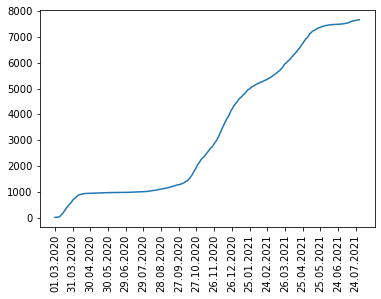

In [19]:
plt.xticks([date for date in range(first_date, last_date+1, 86400000*30)],
          [unix_to_utc(date) for date in range(first_date, last_date+1, 86400000*30)], rotation='vertical')
plt.plot(dates_unixtime, covid19["8311"]['cases_acc'])

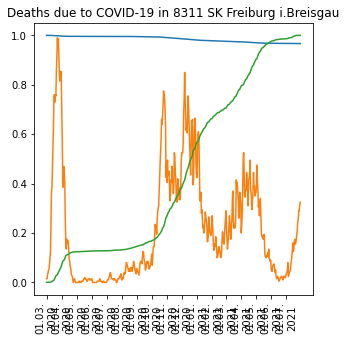

In [20]:
AdmUnitID = "8311"
county = covid19["8311"]
plt.figure(figsize=(5, 5))    # enlarge plot
plt.xticks(first_days_of_months_unixtime, first_days_of_months_utc, rotation='vertical')
# susceptibles
plt.plot(dates_unixtime, [(counties_geography[AdmUnitID]["population"] - county["cases_acc"][i])/
         counties_geography[AdmUnitID]["population"] for i in range(len(county["cases_acc"]))])
# infectious
plt.plot(dates_unixtime,
          [(county['cases_acc'][i] - county['deaths_acc'][i] - county['recovered_acc'][i])
           /200 for i in range(len(county['cases_acc']))])
# removed
plt.plot(dates_unixtime, [(county['deaths_acc'][i] + county['recovered_acc'][i])/
                         (county['deaths_acc'][-1] + county['recovered_acc'][-1])
                         for i in range(len(county['deaths_acc']))])
plt.title("Deaths due to COVID-19 in " + AdmUnitID + " " + counties_geography[AdmUnitID]['name'])
plt.show()

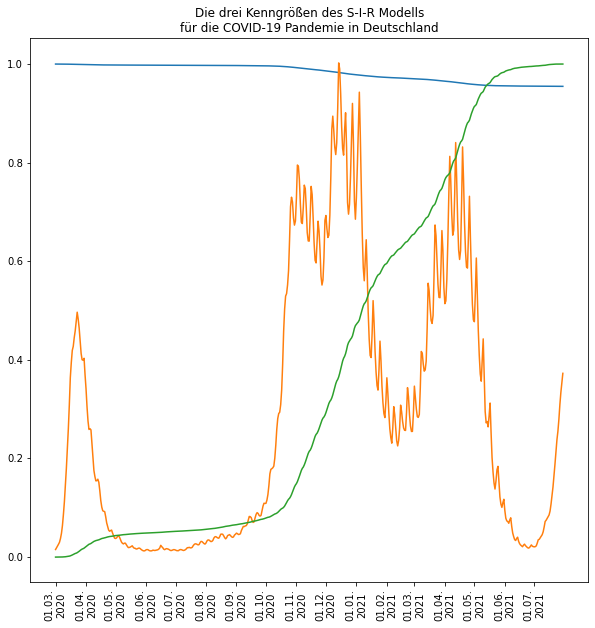

In [21]:
germany_population = sum([counties_geography[AdmUnitID]["population"] for AdmUnitID in covid19.keys()])

germany_cases_acc = [sum([county["cases_acc"][i] for county in covid19.values()])
                        for i in range(len(dates_unixtime))]
germany_deaths_acc = [sum([county["deaths_acc"][i] for county in covid19.values()])
                        for i in range(len(dates_unixtime))]
germany_recovered_acc = [sum([county["recovered_acc"][i] for county in covid19.values()])
                        for i in range(len(dates_unixtime))]

plt.figure(figsize=(10, 10))    # enlarge plot
plt.xticks(first_days_of_months_unixtime, first_days_of_months_utc, rotation='vertical')

# susceptibles
plt.plot(dates_unixtime, [(germany_population - germany_cases_acc[i])/germany_population
                          for i in range(len(dates_unixtime))])
# infectious
plt.plot(dates_unixtime,
          [(germany_cases_acc[i] - germany_deaths_acc[i] - germany_recovered_acc[i])
           /62000 for i in range(len(dates_unixtime))])
# removed
plt.plot(dates_unixtime, [(germany_deaths_acc[i] + germany_recovered_acc[i])/
                         (germany_deaths_acc[-1] + germany_recovered_acc[-1])
                         for i in range(len(dates_unixtime))])
plt.title("Die drei Kenngrößen des S-I-R Modells\n"+
          "für die COVID-19 Pandemie in Deutschland")
plt.show()

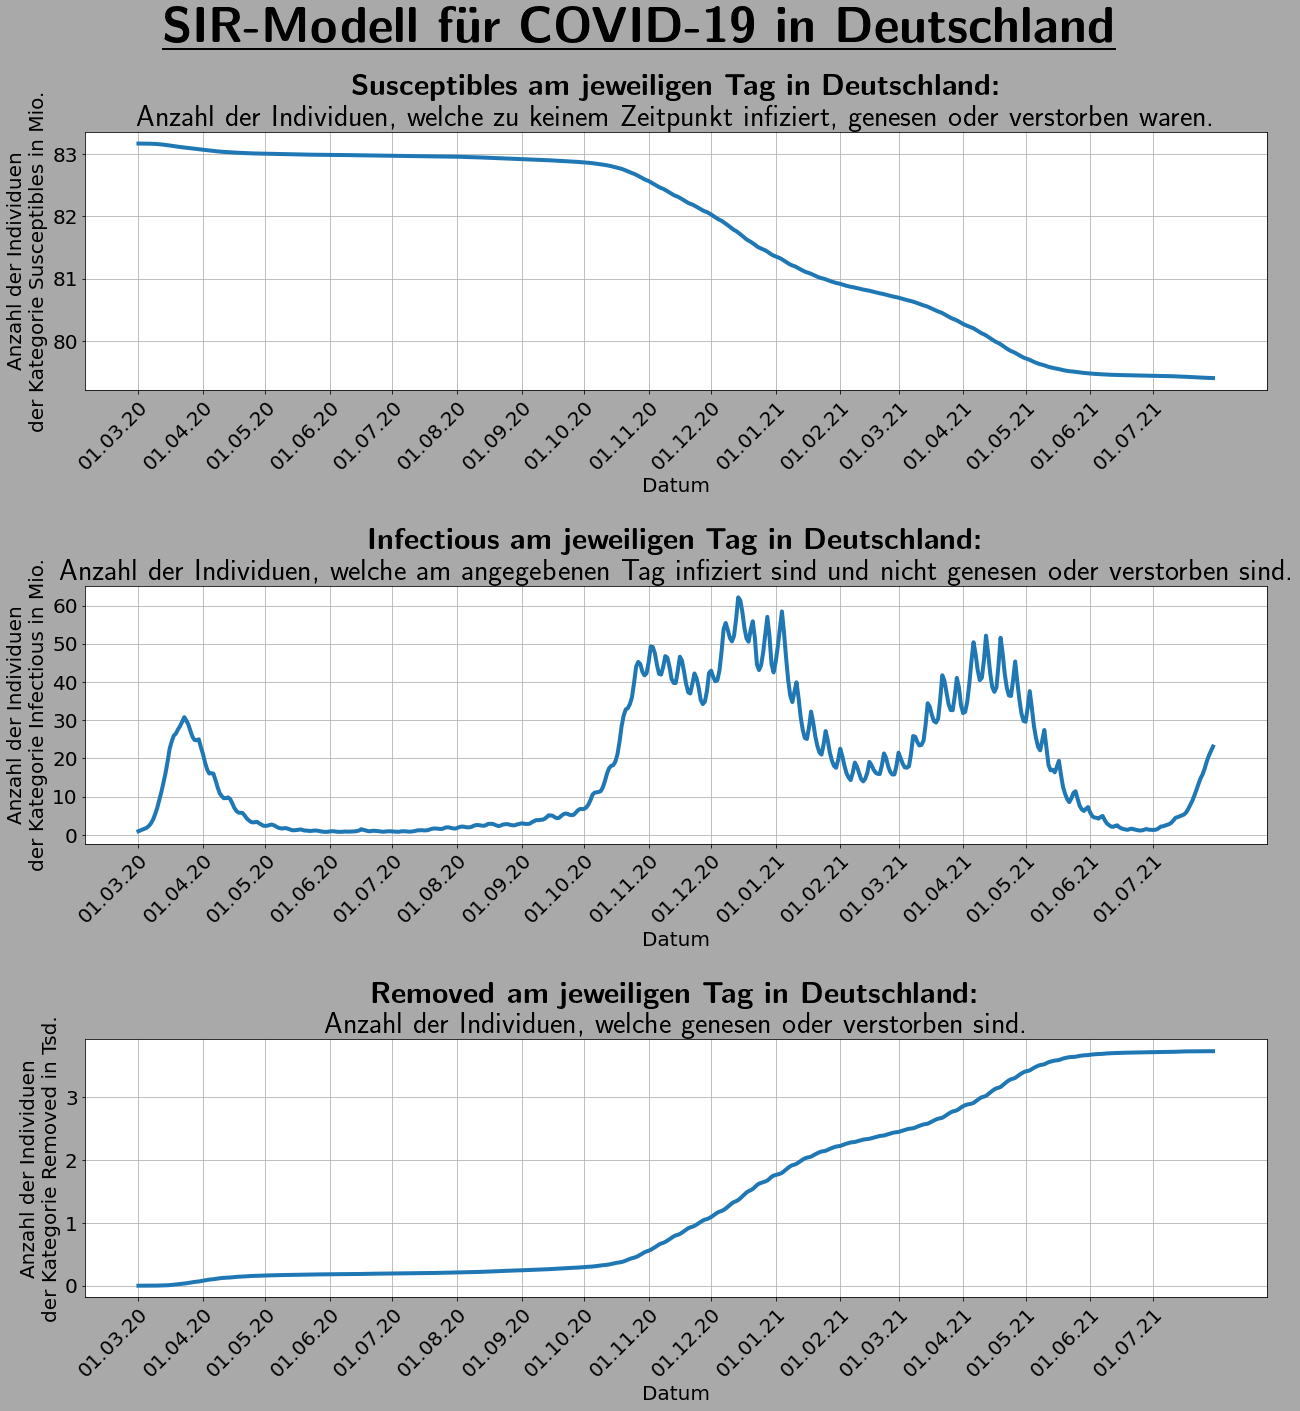

In [22]:
germany_population = sum([counties_geography[AdmUnitID]["population"] for AdmUnitID in covid19.keys()])

germany_cases_acc = [sum([county["cases_acc"][i] for county in covid19.values()])
                        for i in range(len(dates_unixtime))]
germany_deaths_acc = [sum([county["deaths_acc"][i] for county in covid19.values()])
                        for i in range(len(dates_unixtime))]
germany_recovered_acc = [sum([county["recovered_acc"][i] for county in covid19.values()])
                        for i in range(len(dates_unixtime))]
number_of_days = 1
fig, ax = plt.subplots(3, 1, figsize = (18, 20), facecolor='darkgrey')
# susceptibles
axis = ax[0]
plt.sca(axis)
plt.text(1584000000000,84800000,
         r"\textbf{\underline{SIR-Modell für COVID-19 in Deutschland}}",
         fontsize=50, usetex=True)
plt.ylabel("Anzahl der Individuen\nder Kategorie Susceptibles in Mio.", fontsize=20)
plt.yticks([79000000, 80000000, 81000000, 82000000, 83000000],
           ["79", "80", "81", "82", "83"], fontsize=20)
plt.xlabel("Datum", fontsize=20)
plt.xticks(first_days_of_months_unixtime,
           [e[:6] + e[-2:] for e in first_days_of_months_utc],
           rotation=45, ha="right", rotation_mode="anchor", fontsize=20)
plt.grid()
plt.title(r"\textbf{Susceptibles am jeweiligen Tag in Deutschland:}"+
          "\nAnzahl der Individuen, welche zu keinem Zeitpunkt infiziert, "+
          "genesen oder verstorben waren.", usetex=True, fontsize=30)
axis.plot(dates_unixtime, [(germany_population - germany_cases_acc[i])
                          for i in range(len(dates_unixtime))], linewidth=4)

# infectious
axis = ax[1]
plt.sca(axis)
plt.ylabel("Anzahl der Individuen\nder Kategorie Infectious in Mio.", fontsize=20)
plt.xlabel("Datum", fontsize=20)
plt.yticks([0, 10000,20000,30000,40000,50000,60000], [0,10,20,30,40,50,60], fontsize=20)
plt.xticks(first_days_of_months_unixtime,
           [e[:6] + e[-2:] for e in first_days_of_months_utc],
           rotation=45, ha="right", rotation_mode="anchor", fontsize=20)
plt.grid()
plt.title(r"\textbf{Infectious am jeweiligen Tag in Deutschland:}"+
          "\nAnzahl der Individuen, welche am angegebenen Tag infiziert "+
          "sind und nicht genesen oder verstorben sind.", usetex=True, fontsize=30)
axis.plot(dates_unixtime[:(len(dates_unixtime)//number_of_days)*number_of_days:number_of_days],
          [(sum(germany_cases_acc[i:i+number_of_days])
            - sum(germany_deaths_acc[i:i+number_of_days])
            - sum(germany_recovered_acc[i:i+number_of_days]))
           for i in range(0, (len(dates_unixtime)//number_of_days)*number_of_days,
                          number_of_days)], linewidth=4)

# removed
axis = ax[2]
plt.sca(axis)
plt.ylabel("Anzahl der Individuen\nder Kategorie Removed in Tsd.", fontsize=20)
plt.yticks([0, 1000000,2000000,3000000,4000000], [0,1,2,3,4], fontsize=20)
plt.xlabel("Datum", fontsize=20)
plt.xticks(first_days_of_months_unixtime,
           [e[:6] + e[-2:] for e in first_days_of_months_utc],
           rotation=45, ha="right", rotation_mode="anchor", fontsize=20)
plt.grid()
plt.title(r"\textbf{Removed am jeweiligen Tag in Deutschland:}"+
          "\nAnzahl der Individuen, welche "+
          "genesen oder verstorben sind.", usetex=True, fontsize=30)
plt.plot(dates_unixtime, [(germany_deaths_acc[i] + germany_recovered_acc[i])
                         for i in range(len(dates_unixtime))], linewidth=4)

os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/Ergebnisse")): os.makedirs("results/Ergebnisse")
fig.tight_layout(h_pad=3.2)
plt.savefig("results/Ergebnisse/SIR_Modell_Deutschland.png")
os.chdir(SIR_modell_directory)    # return to original directory

In [23]:
len(dates_unixtime)//number_of_days

517